In [5]:
!pip install transformers
!pip install huggingface_hub
!pip install pillow
!pip install opencv-python
!pip install torch torchvision
!pip install kornia
!pip install timm
!pip install torchvision

In [1]:
from transformers import AutoImageProcessor, AutoModelForImageSegmentation
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_softmax

c:\Users\FOCUS\anaconda3\envs\ai_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 모델 로드
model = AutoModelForImageSegmentation.from_pretrained('briaai/RMBG-2.0', trust_remote_code=True)
torch.set_float32_matmul_precision(['high', 'highest'][0])
model.to(device)
model.eval()

# 이미지 경로 설정
input_image_path = 'image_self.jpg'

c:\Users\FOCUS\anaconda3\envs\ai_env\lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\FOCUS\anaconda3\envs\ai_env\lib\site-packages\timm\models\registry.py:4: FutureWarning: Importing from timm.models.registry is deprecated, please import via timm.models
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.models", FutureWarning)


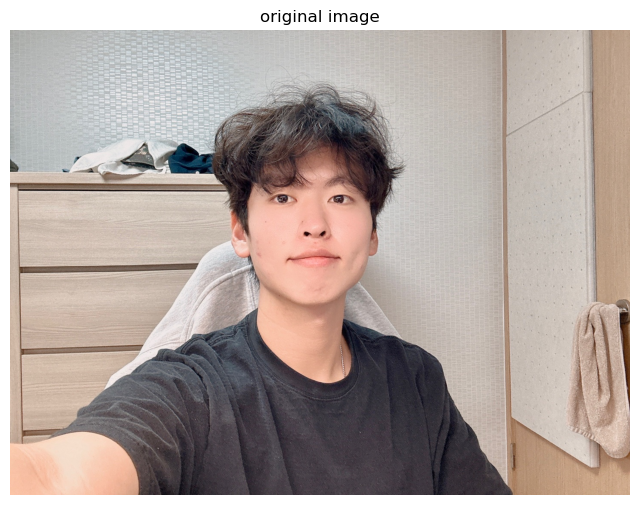

In [3]:
# 원본 이미지 로드 및 표시
original_image = Image.open(input_image_path).convert('RGB')
plt.figure(figsize=(8, 8))
plt.imshow(original_image)
plt.title('original image')
plt.axis('off')
plt.show()

In [22]:
# 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# 이미지 로드 및 전처리
image = Image.open(input_image_path)
input_images = transform_image(image).unsqueeze(0).to(device)

In [23]:
# 모델 추론
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.BILINEAR)

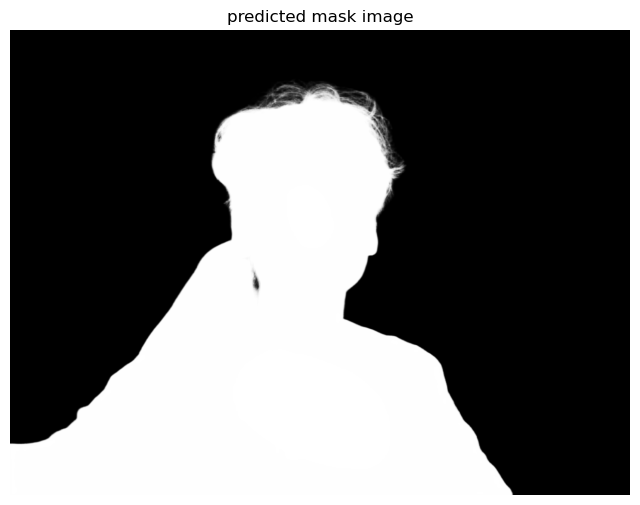

In [24]:
# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image')
plt.axis('off')
plt.show()

In [25]:
# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.NEAREST)

# 마스크 이진화
mask_np = np.array(mask)
binary_mask = (mask_np > 0.5).astype(np.uint8) * 255
alpha_image = Image.fromarray(binary_mask, mode='L')

# 원본 이미지에 알파 채널 추가
image_rgba = image.convert('RGBA')
image_rgba.putalpha(alpha_image)

# 전경 이미지 추출
foreground_np = np.array(image_rgba)

# 배경 흐리게 처리
image_np = np.array(image.convert('RGB'))
blurred_background = cv2.GaussianBlur(image_np, (101, 101), 0)

# 알파 채널 추출
alpha_channel = binary_mask / 255.0
foreground_rgb = foreground_np[:, :, :3]

# 합성
combined = foreground_rgb * alpha_channel[:, :, np.newaxis] + blurred_background * (1 - alpha_channel[:, :, np.newaxis])
combined = combined.astype(np.uint8)


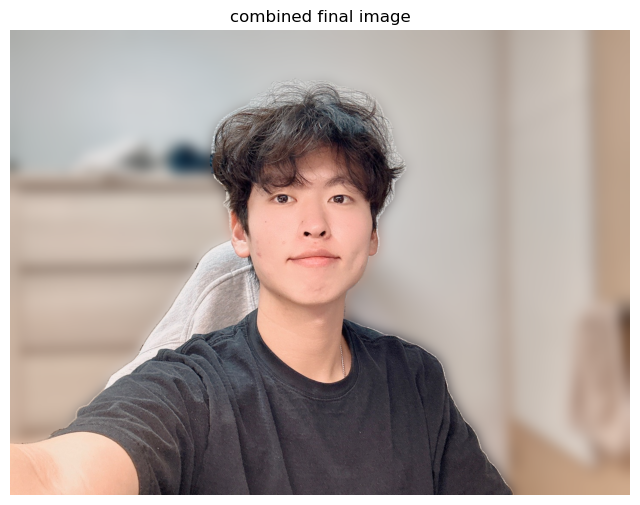

In [26]:
# 합성된 이미지 표시
plt.figure(figsize=(8, 8))
plt.imshow(combined)
plt.title('combined final image')
plt.axis('off')
plt.show()

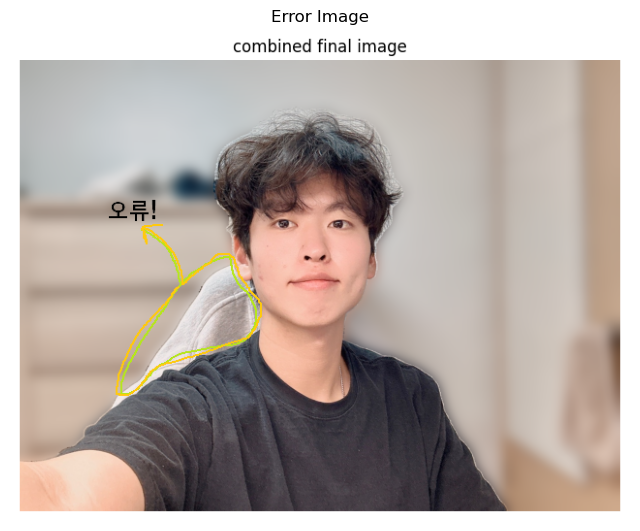

In [27]:
# 이미지 파일 경로
image_path = "error.png"

# 이미지 로드
image = Image.open(image_path)

# 이미지 출력
plt.figure(figsize=(8, 8))  # 크기를 조정할 수 있음
plt.imshow(image)
plt.axis("off")  # 축 제거
plt.title("Error Image")  # 이미지 제목
plt.show()


오류 잡는법 두가지

1. 일단은 모델 자체 성능을 높여본다  
2. 채신 기술을 적용해서 Segmentation을 개선해본다.

1. 모델 자체 성능 개선하기

In [4]:
# 이미지 경로 설정
input_image_path = 'image_self.jpg'

# 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (3840, 3840) # 입력 이미지 크기 증가 (1024 -> 2048 -> 3072 -> 3200 -> 4160)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# 이미지 로드 및 전처리
image = Image.open(input_image_path)
input_images = transform_image(image).unsqueeze(0).to(device)

In [5]:
# 모델 추론
with torch.no_grad():
    preds = model(input_images)[-1].sigmoid().cpu()
pred = preds[0].squeeze()

: 

In [68]:
# 마스크 생성 및 리사이즈
pred_pil = transforms.ToPILImage()(pred)
mask = pred_pil.resize(image.size, resample=Image.BICUBIC)

# 마스크를 NumPy 배열로 변환
mask_np = np.array(mask)

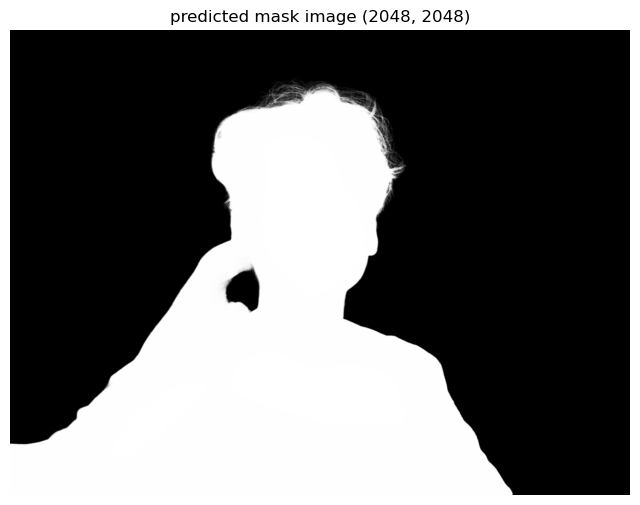

In [51]:
# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image (2048, 2048)')
plt.axis('off')
plt.show()

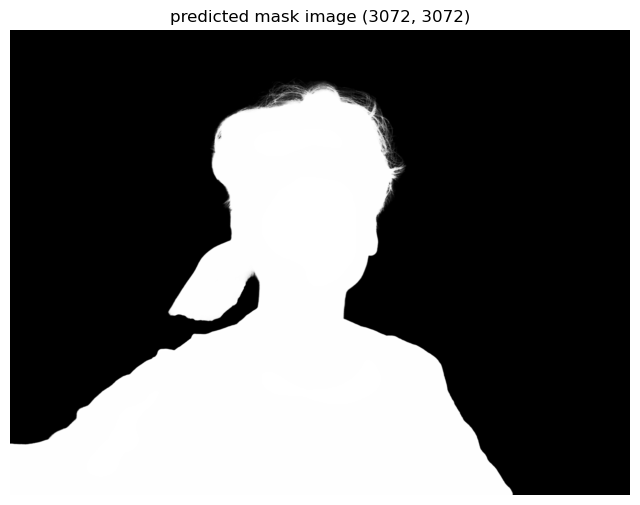

In [56]:
# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image (3072, 3072)')
plt.axis('off')
plt.show()

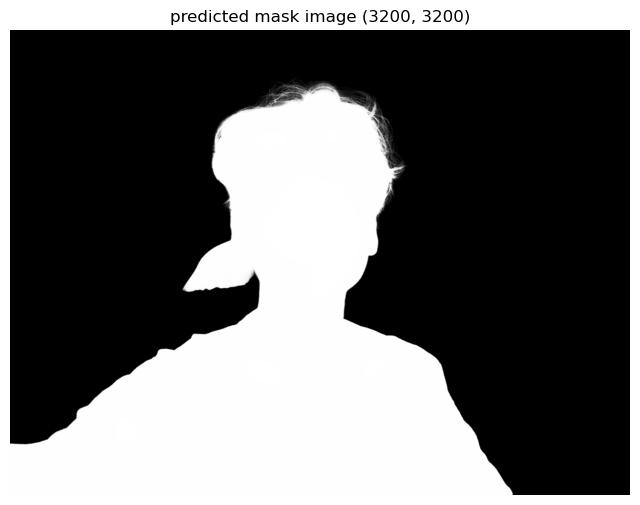

In [65]:
# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image (3200, 3200)')
plt.axis('off')
plt.show()

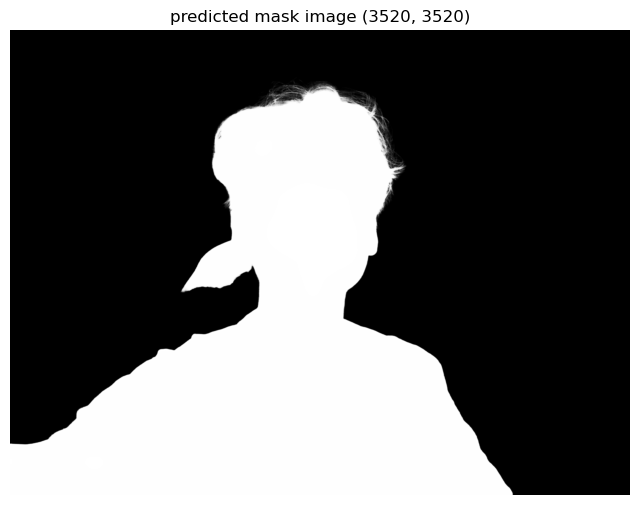

In [ ]:
# 마스크 표시
plt.figure(figsize=(8, 8))
plt.imshow(mask, cmap='gray')
plt.title('predicted mask image (3520, 3520)')
plt.axis('off')
plt.show()

3520에서 그 이상 이미지를 키워서 처리할 수가 없었다.    
메모리 문제 때문에 커널이 자꾸 죽어버리는 현상이 생겼다.   
4160을 4분할 해서 처리한다음 다시 합치는 시도도 해보았으나 아래의 이미지를 보다시피   
당연하게도, 매끄럽게 합쳐지지 않고 성능도 퇴보했다.   
모델의 성능 증가는 여기가 한계인듯 하다. 이제 채신기술로 넘어가보자.   

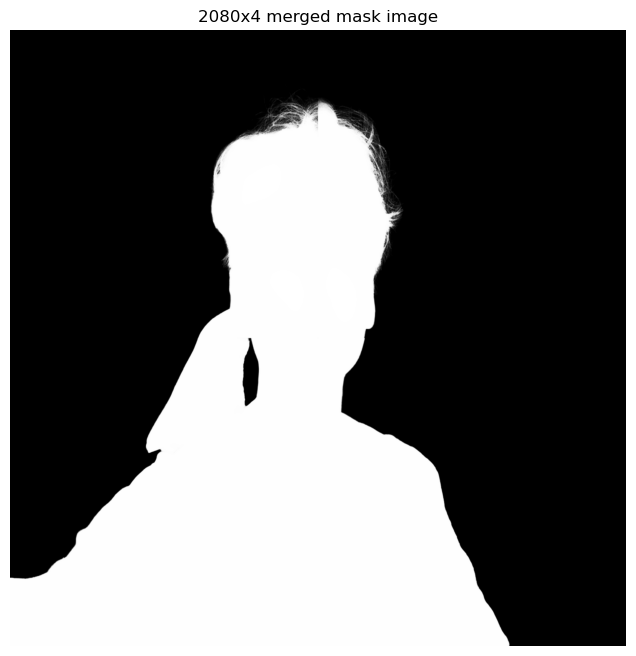

In [ ]:
# 마스크 시각화
plt.figure(figsize=(8, 8))
plt.imshow(final_mask, cmap='gray')
plt.title('2080x4 merged mask image')
plt.axis('off')
plt.show()

채신기술 1. CRF를 사용한 마스크 후처리  
Conditional Random Fields(CRF)는 확률 그래픽 모델의 한 종류로,   
데이터를 구조적으로 모델링하고 예측을 개선하는 데 사용됩니다.    
주로 마스크 후처리에서 픽셀 간의 관계를 활용하여 세그멘테이션 품질을 향상시키는 데 효과적입니다.   
  
CRF 적용 전:  
딥 러닝 모델이 생성한 초기 마스크를 준비합니다.  
  
CRF 적용:  
초기 마스크와 원본 이미지를 입력으로 사용하여 페어와이즈 포텐셜을 계산합니다.  
픽셀 간의 관계를 반영한 결과를 도출합니다.  

CRF 적용 후:  
정제된 마스크를 얻어 후처리 과정에서 사용합니다.  

In [9]:
# 이미지 전처리 함수
def transform_image(image):
    transform = transforms.Compose([
        transforms.Resize((3520, 3520)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # 모델의 학습 시 사용된 평균과 표준편차
            std=[0.229, 0.224, 0.225]
        )
    ])
    return transform(image)

# CRF 적용 함수 (파라미터 조정)
def apply_crf(image, mask_prob):
    image_np = np.array(image)
    mask_prob_np = mask_prob.squeeze().cpu().numpy()
    if image_np.shape[:2] != mask_prob_np.shape:
        mask_prob_np = cv2.resize(mask_prob_np, (image_np.shape[1], image_np.shape[0]))

    d = dcrf.DenseCRF2D(image_np.shape[1], image_np.shape[0], 2)
    unary = unary_from_softmax(np.stack([1 - mask_prob_np, mask_prob_np], axis=0))
    d.setUnaryEnergy(unary)

    # 파라미터 조정
    sxy_gaussian = 10
    compat_gaussian = 10
    sxy_bilateral = 20
    srgb_bilateral = 5
    compat_bilateral = 20
    n_iterations = 10

    d.addPairwiseGaussian(sxy=sxy_gaussian, compat=compat_gaussian)
    d.addPairwiseBilateral(sxy=sxy_bilateral, srgb=srgb_bilateral, rgbim=image_np, compat=compat_bilateral)

    Q = d.inference(n_iterations)
    refined_mask = np.argmax(Q, axis=0).reshape((image_np.shape[0], image_np.shape[1]))
    return refined_mask

# 이미지 경로 설정
input_image_path = 'image_self.jpg'
image = Image.open(input_image_path).convert('RGB')

# 이미지 전처리
input_image = transform_image(image).unsqueeze(0).to(device)

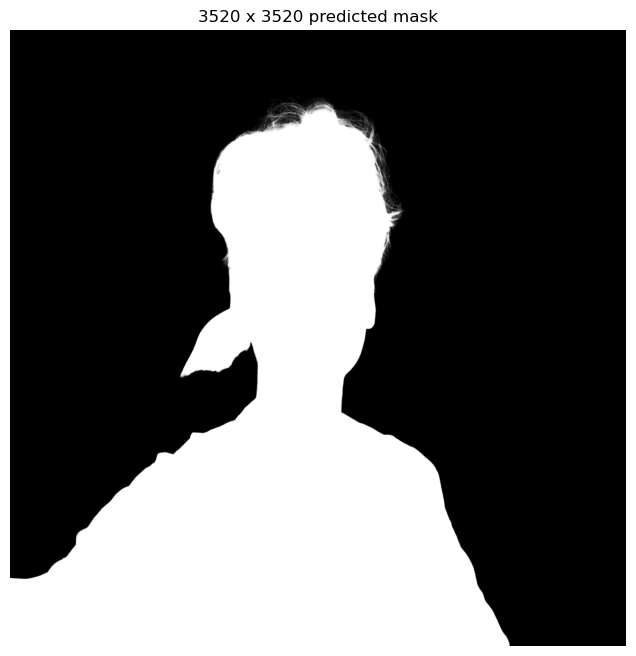

In [5]:
# 모델 추론
with torch.no_grad():
    preds = model(input_image)[-1].sigmoid()

# 초기 마스크 시각화
pred_mask = preds[0].squeeze().cpu().numpy()
plt.figure(figsize=(8, 8))
plt.imshow(pred_mask, cmap='gray')
plt.title('3520 x 3520 predicted mask')
plt.axis('off')
plt.show()

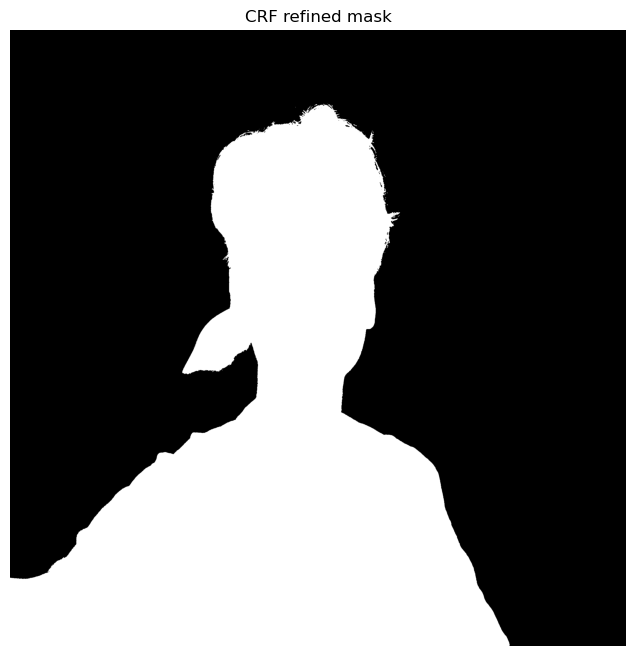

In [10]:
# CRF 적용
refined_mask = apply_crf(image.resize((3520, 3520)), preds[0])

# CRF 적용 후 마스크 시각화
plt.figure(figsize=(8, 8))
plt.imshow(refined_mask, cmap='gray')
plt.title('CRF refined mask')
plt.axis('off')
plt.show()

CRF를 여러 파라미터 수치를 조정해서 돌려봤지만, 후처리의 한계였다.   
그냥 애초부터 인식을 잘해야 되는거였어...  
   
채신기술2.DeepLabV3+ 모델을 사용.   

c:\Users\FOCUS\anaconda3\envs\ai_env\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\FOCUS\anaconda3\envs\ai_env\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to C:\Users\FOCUS/.cache\torch\hub\checkpoints\deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:22<00:00, 10.9MB/s] 


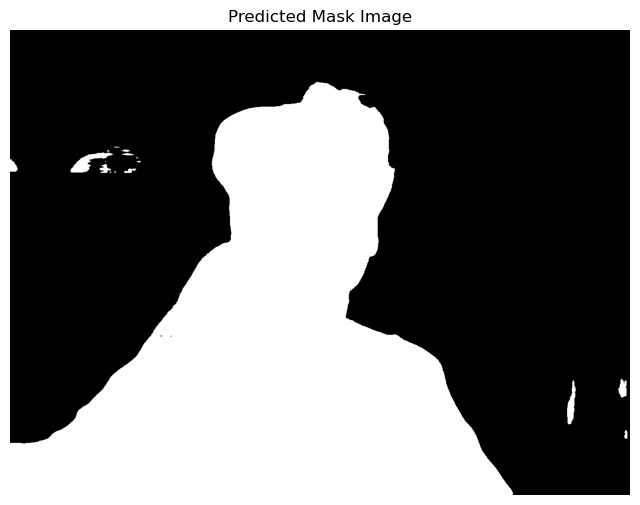

In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pydensecrf.densecrf as dcrf
from pydensecrf.utils import unary_from_labels

# 1. 환경 설정 및 모델 로드
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.segmentation.deeplabv3_resnet101(pretrained=True)
model = model.to(device)
model.eval()

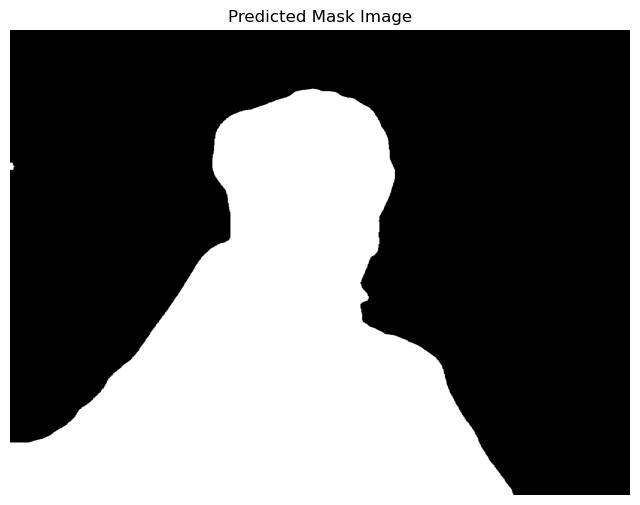

In [26]:
# 2. 이미지 전처리 함수
def transform_image(image):
    # 알파 채널 제거
    if image.mode == 'RGBA':
        image = image.convert('RGB')

    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size, interpolation=transforms.InterpolationMode.BILINEAR),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],  # 모델의 학습 시 사용된 평균
            std=[0.229, 0.224, 0.225]    # 모델의 학습 시 사용된 표준편차
        )
    ])
    return transform(image)

# 3. 이미지 로드 및 전처리
input_image_path = 'image_self.jpg'
image = Image.open(input_image_path)
input_tensor = transform_image(image).unsqueeze(0).to(device)

# 4. 모델 추론
with torch.no_grad():
    output = model(input_tensor)['out'][0]
    output_predictions = output.argmax(0).cpu().numpy()

# 5. 마스크 리사이즈 및 시각화
def resize_mask(mask, original_size):
    mask_pil = Image.fromarray(mask.astype(np.uint8))
    mask_pil = mask_pil.resize(original_size, resample=Image.NEAREST)
    return np.array(mask_pil)

original_size = image.size
resized_mask = resize_mask(output_predictions, original_size)

# 마스크 시각화
plt.figure(figsize=(8, 8))
plt.imshow(resized_mask, cmap='gray')
plt.title('Predicted Mask Image')
plt.axis('off')
plt.show()

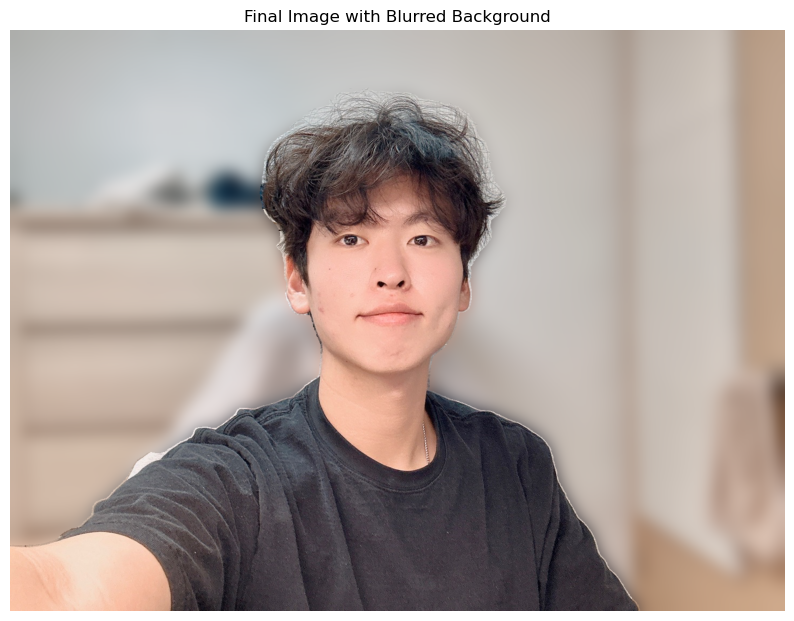

In [28]:
from transformers import AutoModelForImageSegmentation
from PIL import Image
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms

# 디바이스 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# BiRefNet 모델 로드
birefnet = AutoModelForImageSegmentation.from_pretrained('ZhengPeng7/BiRefNet', trust_remote_code=True)
birefnet.to(device)
birefnet.eval()

# 이미지 전처리 함수
def transform_image(image):
    if image.mode == 'RGBA':  # 알파 채널 제거
        image = image.convert('RGB')
    
    image_size = (1024, 1024)
    transform = transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    return transform(image)

# 객체 추출 함수 정의
def extract_object(birefnet, imagepath):
    # 이미지 불러오기 및 전처리
    image = Image.open(imagepath).convert("RGB")
    input_images = transform_image(image).unsqueeze(0).to(device)

    # 모델 추론
    with torch.no_grad():
        preds = birefnet(input_images)[-1].sigmoid().cpu()
    pred = preds[0].squeeze()

    # 마스크 생성
    pred_pil = transforms.ToPILImage()(pred)
    mask = pred_pil.resize(image.size, resample=Image.BILINEAR)
    image.putalpha(mask)
    return image, mask

# 배경 흐리게 및 이미지 합성
def apply_blur_and_combine(image, mask):
    mask_np = np.array(mask)
    binary_mask = (mask_np > 0.5).astype(np.uint8) * 255

    # 원본 이미지 및 알파 채널 처리
    alpha_image = Image.fromarray(binary_mask, mode='L')
    image_rgba = image.convert('RGBA')
    image_rgba.putalpha(alpha_image)
    foreground_np = np.array(image_rgba)

    # 배경 흐리게 처리
    image_np = np.array(image.convert('RGB'))
    blurred_background = cv2.GaussianBlur(image_np, (101, 101), 0)

    # 알파 채널 추출
    alpha_channel = binary_mask / 255.0
    foreground_rgb = foreground_np[:, :, :3]

    # 합성
    combined = foreground_rgb * alpha_channel[:, :, np.newaxis] + blurred_background * (1 - alpha_channel[:, :, np.newaxis])
    combined = combined.astype(np.uint8)
    return combined

# 이미지 경로
input_image_path = 'image_self.jpg'

# 객체 추출
result_image, mask = extract_object(birefnet, imagepath=input_image_path)

# 흐림 효과와 합성 적용
final_image = apply_blur_and_combine(result_image, mask)

# 결과 이미지 시각화
plt.figure(figsize=(10, 10))
plt.axis("off")
plt.title("Final Image with Blurred Background")
plt.imshow(final_image)
plt.show()

회고 - 권오근 : 다양한 후처리를 시도했으나 결국 처음부터 예측을 잘해야함을 깨달았다. 후처리에 집중하느라 모델을 바꿔 볼 생각을 늦게 했다는게 아쉬웠다.
그래도 성공했으니 기분이 좋다!!